In [ ]:
from pathlib import Path

import plotnine as pn
import scanpy as sc
import partipy as pt

import pandas as pd
import decoupler as dc


figure_dir = Path("figures") / "fibroblast_cross_condition"
figure_dir.mkdir(exist_ok=True, parents=True)
sc.settings.figdir = figure_dir

output_dir = Path("output") / "fibroblast_cross_condition"
output_dir.mkdir(exist_ok=True, parents=True)

n_archetypes = 3
obsm_key = "X_pca_harmony"
obsm_dim = 16

color_dict = {
    "NF": "#01665E",  # teal (blue-green)
    "CM": "#8C510A",  # brown
}

adata = pt.read_h5ad("/home/pschaefer/fibroblast_cross_condition_partipy.h5ad")

msigdb_cache_path = output_dir / "msigdb_raw.pkl"
needs_cache_write = False
if msigdb_cache_path.exists():
    msigdb_raw = pd.read_pickle(msigdb_cache_path)
else:
    msigdb_raw = dc.op.resource("MSigDB")
    needs_cache_write = True

if msigdb_raw.duplicated(["geneset", "genesymbol"]).any():
    msigdb_raw = msigdb_raw[~msigdb_raw.duplicated(["geneset", "genesymbol"])].copy()
    needs_cache_write = True

if needs_cache_write:
    msigdb_raw.to_pickle(msigdb_cache_path)

aa_out = pt.get_aa_result(adata, n_archetypes=3)
adata.obs["archetype_max_weight"] = aa_out["A"].argmax(axis=1)

enrichment_df = pd.read_csv(output_dir / "enrichment_df.csv")
enrichment_df["enriched"] = (enrichment_df["pval_adj"] <= 0.05) & (
    enrichment_df["mean_diff"] > 0.0
)

arch_expr_long = pd.read_csv(output_dir / "archetype_expression_pivot.csv")
arch_expr_long["arch_idx"] = (
    arch_expr_long["archetype"].str.extract(r"arch_([0-9]+)").astype(int)
)
arch_expr_long = arch_expr_long.drop(columns=["archetype"])
arch_expr_long

,gene,raw,log1p,z_scaled,arch_idx
0,A1BG,0.010071,0.005810,-0.029893,0
1,A1BG-AS1,0.009757,0.005684,-0.029976,0
2,A2M,0.155659,0.068402,0.016576,0
3,A2M-AS1,0.003757,0.001276,-0.021860,0
4,A2ML1,0.009006,0.005230,-0.021868,0
...,...,...,...,...,...
64012,ZXDC,0.207980,0.114375,-0.005273,2
64013,ZYG11A,0.004195,0.002434,-0.019296,2
64014,ZYG11B,0.165848,0.091198,0.006443,2
64015,ZYX,0.041885,0.022275,-0.020601,2


In [21]:
comparison_df = enrichment_df.join(
    arch_expr_long.set_index(["arch_idx", "gene"]), on=["arch_idx", "gene"], how="left"
)
comparison_df.sort_values("z_scaled", ascending=False)

,arch_idx,gene,stat,pval,mean_diff,median_diff,mean_bin0,mean_rest,median_bin0,median_rest,max_in_bin0,pos_effect,pval_adj,signif,enriched,raw,log1p,z_scaled
35049,1,POSTN,1.613909e+09,0.0,1.151820,1.282422,1.280667,0.128847,1.282422,0.000000,True,True,0.0,True,True,3.177242,0.669108,0.689743
35286,1,FGF14,1.614826e+09,0.0,1.036476,1.625877,1.535076,0.498600,1.625877,0.000000,True,True,0.0,True,True,3.807233,1.076741,0.622455
27354,1,THBS4,1.518080e+09,0.0,0.792732,0.939645,0.990331,0.197599,0.939645,0.000000,True,True,0.0,True,True,1.966552,0.598376,0.578533
58508,2,ACSM3,1.624454e+09,0.0,1.178305,1.461151,2.001555,0.823250,2.063619,0.602468,True,True,0.0,True,True,7.007072,1.492596,0.573604
45655,2,SCN7A,1.580829e+09,0.0,0.868771,0.889986,1.811543,0.942772,1.850017,0.960031,True,True,0.0,True,True,5.129171,1.477664,0.561420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21573,1,PLA2G5,6.132826e+08,0.0,-0.454353,0.000000,0.119418,0.573771,0.000000,0.000000,False,False,0.0,True,False,0.757415,0.277878,-0.364098
28575,1,ADGRB3,6.121415e+08,0.0,-0.469408,-0.203611,0.141077,0.610485,0.000000,0.203611,False,False,0.0,True,False,0.780216,0.308773,-0.366491
27140,1,C7,5.608701e+08,0.0,-0.538258,-0.696889,0.212362,0.750620,0.000000,0.696889,False,False,0.0,True,False,0.991653,0.390632,-0.419055
21511,1,KAZN,6.753328e+08,0.0,-0.499715,0.000000,0.065035,0.564749,0.000000,0.000000,False,False,0.0,True,False,0.450543,0.148982,-0.430557


In [31]:
comparison_df = enrichment_df.join(
    arch_expr_long.set_index(["arch_idx", "gene"]), on=["arch_idx", "gene"], how="left"
)
comparison_df.to_csv(output_dir / "comparison_df.csv", index=False)


def helper_compute_corr(df):
    r, p = pearsonr(df["z_scaled"], df["stat"])
    return pd.Series({"r": r, "p": p, "label": f"r = {r:.2f}\np = {p:.2e}"})


corr_df = comparison_df.groupby("arch_idx", as_index=False).apply(helper_compute_corr)

pos_df = (
    comparison_df.groupby("arch_idx")
    .agg(x=("z_scaled", "min"), y=("stat", "max"))
    .reset_index()
)

corr_df = corr_df.merge(pos_df, on="arch_idx")

p = (
    pn.ggplot(comparison_df)
    + pn.geom_point(
        pn.aes(x="z_scaled", y="stat", color="enriched"), alpha=0.5, size=1.0
    )
    + pn.geom_smooth(
        pn.aes(x="z_scaled", y="stat"), method="lm", alpha=0.5, color="grey"
    )
    + pn.geom_text(
        corr_df, pn.aes(x="x", y="y", label="label"), ha="left", va="top", size=8
    )
    + pn.facet_wrap("arch_idx")
    + pn.labs(x="z-scored Gene Expression", y="Test Statistic", color="Enriched")
    + pn.theme_bw()
    + pn.theme(
        figure_size=(9, 3),
        axis_title_x=pn.element_text(size=14),
        axis_title_y=pn.element_text(size=14),
        axis_text_x=pn.element_text(size=11),
        axis_text_y=pn.element_text(size=11),
        legend_title=pn.element_text(size=12),
        legend_text=pn.element_text(size=9),
        strip_background=pn.element_rect(fill="white", color="black"),
        strip_text=pn.element_text(color="black"),
    )
    + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1, "size": 3}))
)
p.save(figure_dir / "enrichment_comparison_scatter_plot.pdf", verbose=False)
p.save(figure_dir / "enrichment_comparison_scatter_plot.png", verbose=False, dpi=300)

/tmp/ipykernel_3214372/2751565948.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


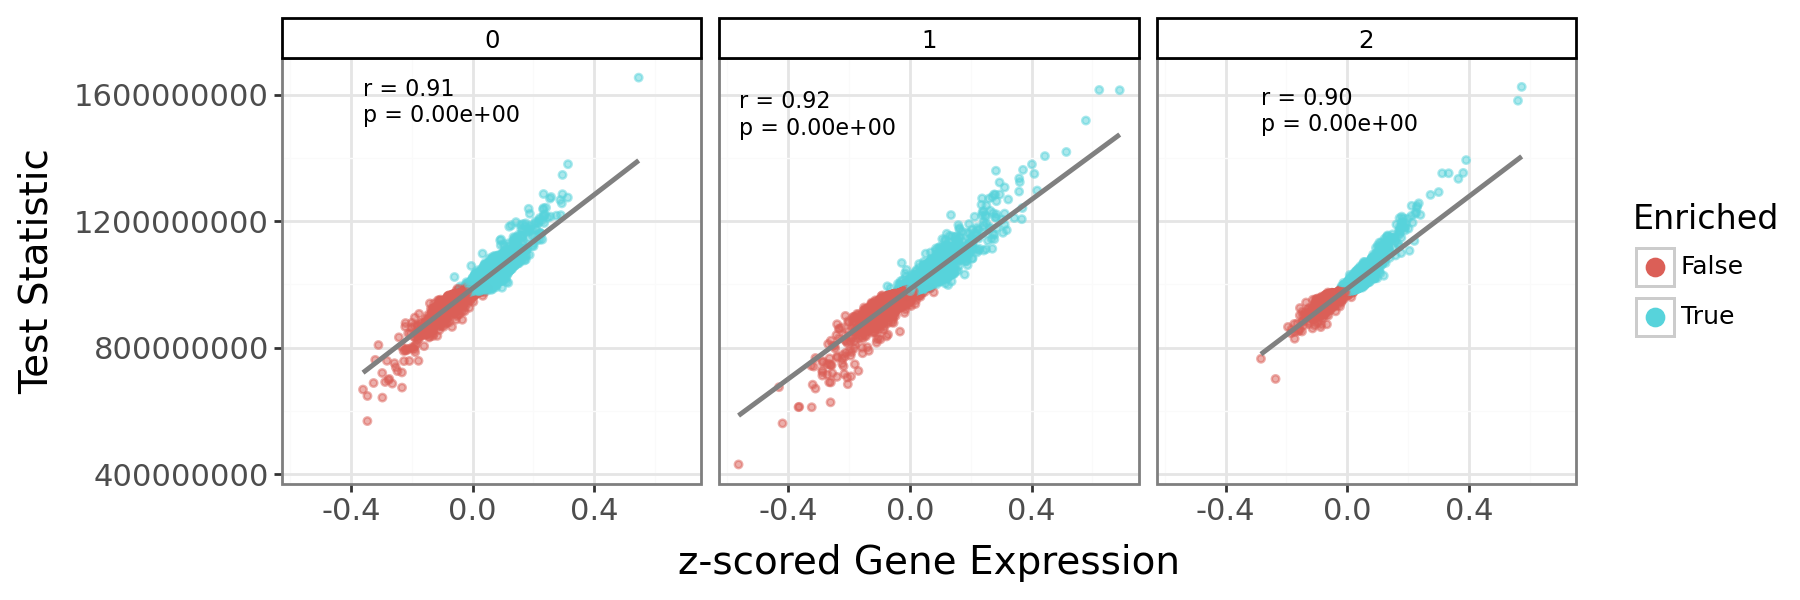

In [32]:
p.show()

In [35]:
df.sort_values("zscore", ascending=False)

,Unnamed: 0,arch_idx,gene,stat,pval,mean_diff,median_diff,mean_bin0,mean_rest,median_bin0,median_rest,max_in_bin0,pos_effect,pval_adj,signif,enriched,zscore
10633,10633,0,NRP1,1.184582e+09,0.0,0.235062,0.000000,0.393625,0.158563,0.000000,0.000000,True,False,0.0,True,False,0.219398
4149,4149,0,LSAMP,1.203331e+09,0.0,0.292035,0.000000,0.394596,0.102561,0.000000,0.000000,True,False,0.0,True,False,0.211843
8679,8679,0,CNTNAP2,1.102379e+09,0.0,0.183551,0.000000,0.260392,0.076842,0.000000,0.000000,True,False,0.0,True,False,0.203513
13157,13157,0,NAV3,1.210189e+09,0.0,0.306602,0.000000,0.573253,0.266651,0.000000,0.000000,True,False,0.0,True,False,0.186799
13897,13897,0,GPC6,1.141192e+09,0.0,0.228682,0.000000,0.495934,0.267252,0.000000,0.000000,True,False,0.0,True,False,0.185811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,2977,0,SCN7A,5.956905e+08,0.0,-0.541388,-1.134501,0.542401,1.083789,0.000000,1.134501,False,False,0.0,True,False,-0.243887
15832,15832,0,THUMPD1,7.193652e+08,0.0,-0.247469,0.000000,0.054650,0.302119,0.000000,0.000000,False,False,0.0,True,False,-0.253694
15831,15831,0,ACSM1,7.136179e+08,0.0,-0.246423,0.000000,0.036114,0.282537,0.000000,0.000000,False,False,0.0,True,False,-0.258367
7505,7505,0,LAMA2,5.284310e+08,0.0,-0.629912,-0.623929,1.882201,2.512112,2.013258,2.637187,False,False,0.0,True,False,-0.311473


In [29]:
corr_df

,arch_idx,r,p,label
0,0,0.914312,0.0,r = 0.91\np = 0.00e+00
1,1,0.920942,0.0,r = 0.92\np = 0.00e+00
2,2,0.898834,0.0,r = 0.90\np = 0.00e+00


In [ ]:
enrich_subset.join()

,Unnamed: 0,arch_idx,gene,stat,pval,mean_diff,median_diff,mean_bin0,mean_rest,median_bin0,median_rest,max_in_bin0,pos_effect,pval_adj,signif,enriched
0,0,0,AL627309.1,975676615.0,5.301237e-01,0.000752,0.0,0.003439,0.002687,0.0,0.0,True,False,5.982500e-01,False,False
1,1,0,AL627309.5,973792166.5,9.544571e-03,-0.000369,0.0,0.002362,0.002732,0.0,0.0,True,False,1.666571e-02,True,False
2,2,0,AP006222.2,975207545.0,6.755719e-01,0.000032,0.0,0.000551,0.000519,0.0,0.0,True,False,7.316667e-01,False,False
3,3,0,LINC01409,960687326.0,2.152452e-08,-0.000522,0.0,0.066226,0.066748,0.0,0.0,True,False,7.771771e-08,True,False
4,4,0,FAM87B,975369485.0,8.158270e-01,0.000134,0.0,0.000608,0.000474,0.0,0.0,True,False,8.522511e-01,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21334,21334,0,MAFIP,974502019.5,5.010498e-02,-0.000184,0.0,0.001112,0.001296,0.0,0.0,True,False,7.556648e-02,True,False
21335,21335,0,AC011043.1,973816490.0,7.291639e-02,0.000543,0.0,0.005992,0.005449,0.0,0.0,True,False,1.060281e-01,False,False
21336,21336,0,AL354822.1,973865692.5,1.359572e-01,0.000496,0.0,0.007928,0.007432,0.0,0.0,True,False,1.844485e-01,False,False
21337,21337,0,AL592183.1,979098922.5,2.443857e-01,0.018694,0.0,0.136286,0.117592,0.0,0.0,True,False,3.094740e-01,False,False


In [ ]:
expr_subset["arch_idx"]


,gene,variable,value
0,AL627309.1,arch_0,-0.018383
1,AL627309.5,arch_0,-0.023956
2,AP006222.2,arch_0,-0.019084
3,LINC01409,arch_0,0.003721
4,FAM87B,arch_0,-0.019378
...,...,...,...
21334,MAFIP,arch_0,-0.024845
21335,AC011043.1,arch_0,-0.017673
21336,AL354822.1,arch_0,-0.008180
21337,AL592183.1,arch_0,0.013966


In [19]:
arch_expr_long["variable"].value_counts()

variable
arch_0    21339
arch_1    21339
arch_2    21339
arch_3    21339
Name: count, dtype: int64

In [14]:
enrichment_df["median_bin0"].to_numpy()

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
enrichment_df["median_rest"].to_numpy()

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
enrichment_df.query("enriched")

,Unnamed: 0,arch_idx,gene,stat,pval,mean_diff,median_diff,mean_bin0,mean_rest,median_bin0,median_rest,max_in_bin0,pos_effect,pval_adj,signif,enriched
172,172,0,KAZN,1.160535e+09,0.000000e+00,0.301632,0.363292,0.786246,0.484614,0.363292,0.000000,True,True,0.000000e+00,True,True
748,748,0,JAK1,1.003361e+09,4.149378e-09,0.033525,0.045541,0.662226,0.628701,0.701020,0.655479,True,True,1.603760e-08,True,True
1424,1424,0,PBX1,1.122258e+09,4.338598e-205,0.205040,0.238855,0.968931,0.763891,1.012409,0.773554,True,True,8.340661e-203,True,True
1613,1613,0,CFH,1.131434e+09,9.961074e-257,0.215665,0.646984,0.689325,0.473660,0.646984,0.000000,True,True,3.220596e-254,True,True
2157,2157,0,NCOA1,1.023980e+09,1.050804e-24,0.058113,0.083246,0.636591,0.578477,0.676008,0.592761,True,True,1.193353e-23,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84502,84502,3,MRTFA,1.193944e+09,0.000000e+00,0.182509,0.480089,0.486871,0.304363,0.480089,0.000000,True,True,0.000000e+00,True,True
84978,84978,3,XIST,1.197921e+09,0.000000e+00,0.234239,0.427507,0.541157,0.306918,0.427507,0.000000,True,True,0.000000e+00,True,True
84980,84980,3,JPX,1.063722e+09,3.283570e-87,0.056890,0.388253,0.421703,0.364813,0.388253,0.000000,True,True,3.943056e-86,True,True
85021,85021,3,DIAPH2,1.226626e+09,0.000000e+00,0.228736,0.555926,0.563049,0.334313,0.555926,0.000000,True,True,0.000000e+00,True,True


In [7]:
enrichment_df["median_bin0"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
85351    0.0
85352    0.0
85353    0.0
85354    0.0
85355    0.0
Name: median_bin0, Length: 85356, dtype: float64

In [11]:
enrichment_df["median_rest"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
85351    0.0
85352    0.0
85353    0.0
85354    0.0
85355    0.0
Name: median_rest, Length: 85356, dtype: float64

In [6]:
enrichment_df["max_in_bin0"].value_counts()

max_in_bin0
True     84532
False      824
Name: count, dtype: int64

In [18]:
arch_expr_long["variable"]

0        arch_0
1        arch_0
2        arch_0
3        arch_0
4        arch_0
          ...  
85351    arch_3
85352    arch_3
85353    arch_3
85354    arch_3
85355    arch_3
Name: variable, Length: 85356, dtype: object

In [ ]:
arch_expr_long = pd.read_csv(output_dir / "arch_expr_long.csv")
arch_expr_long

,gene,variable,value
0,AL627309.1,arch_0,-0.018383
1,AL627309.5,arch_0,-0.023956
2,AP006222.2,arch_0,-0.019084
3,LINC01409,arch_0,0.003721
4,FAM87B,arch_0,-0.019378
...,...,...,...
85351,MAFIP,arch_3,-0.017963
85352,AC011043.1,arch_3,-0.012628
85353,AL354822.1,arch_3,-0.002501
85354,AL592183.1,arch_3,-0.050049
